In [2]:
import pyc2ray as pc2r
import numpy as np, yaml
import matplotlib.pyplot as plt

import astropy.units as u

# Memory & Speedup
The great advantage of pyC$^2$Ray is that the re-written raytracing algorithm ($\texttt{ASORA}$) employ GPU for the most computationaly intense calculation.

In this tutorial we show you how to estimate the computing time and the GPU memory you need to run your simulation.

## Raytracing speedup

The algorithm has been tested on a series of NVIDIA GPUs commonly used on HPC and one laptop GPU graphic card. In the figure here below, the panel on the left, present the speedup when compare to the Fortran CPU version, for the different GPU devices:

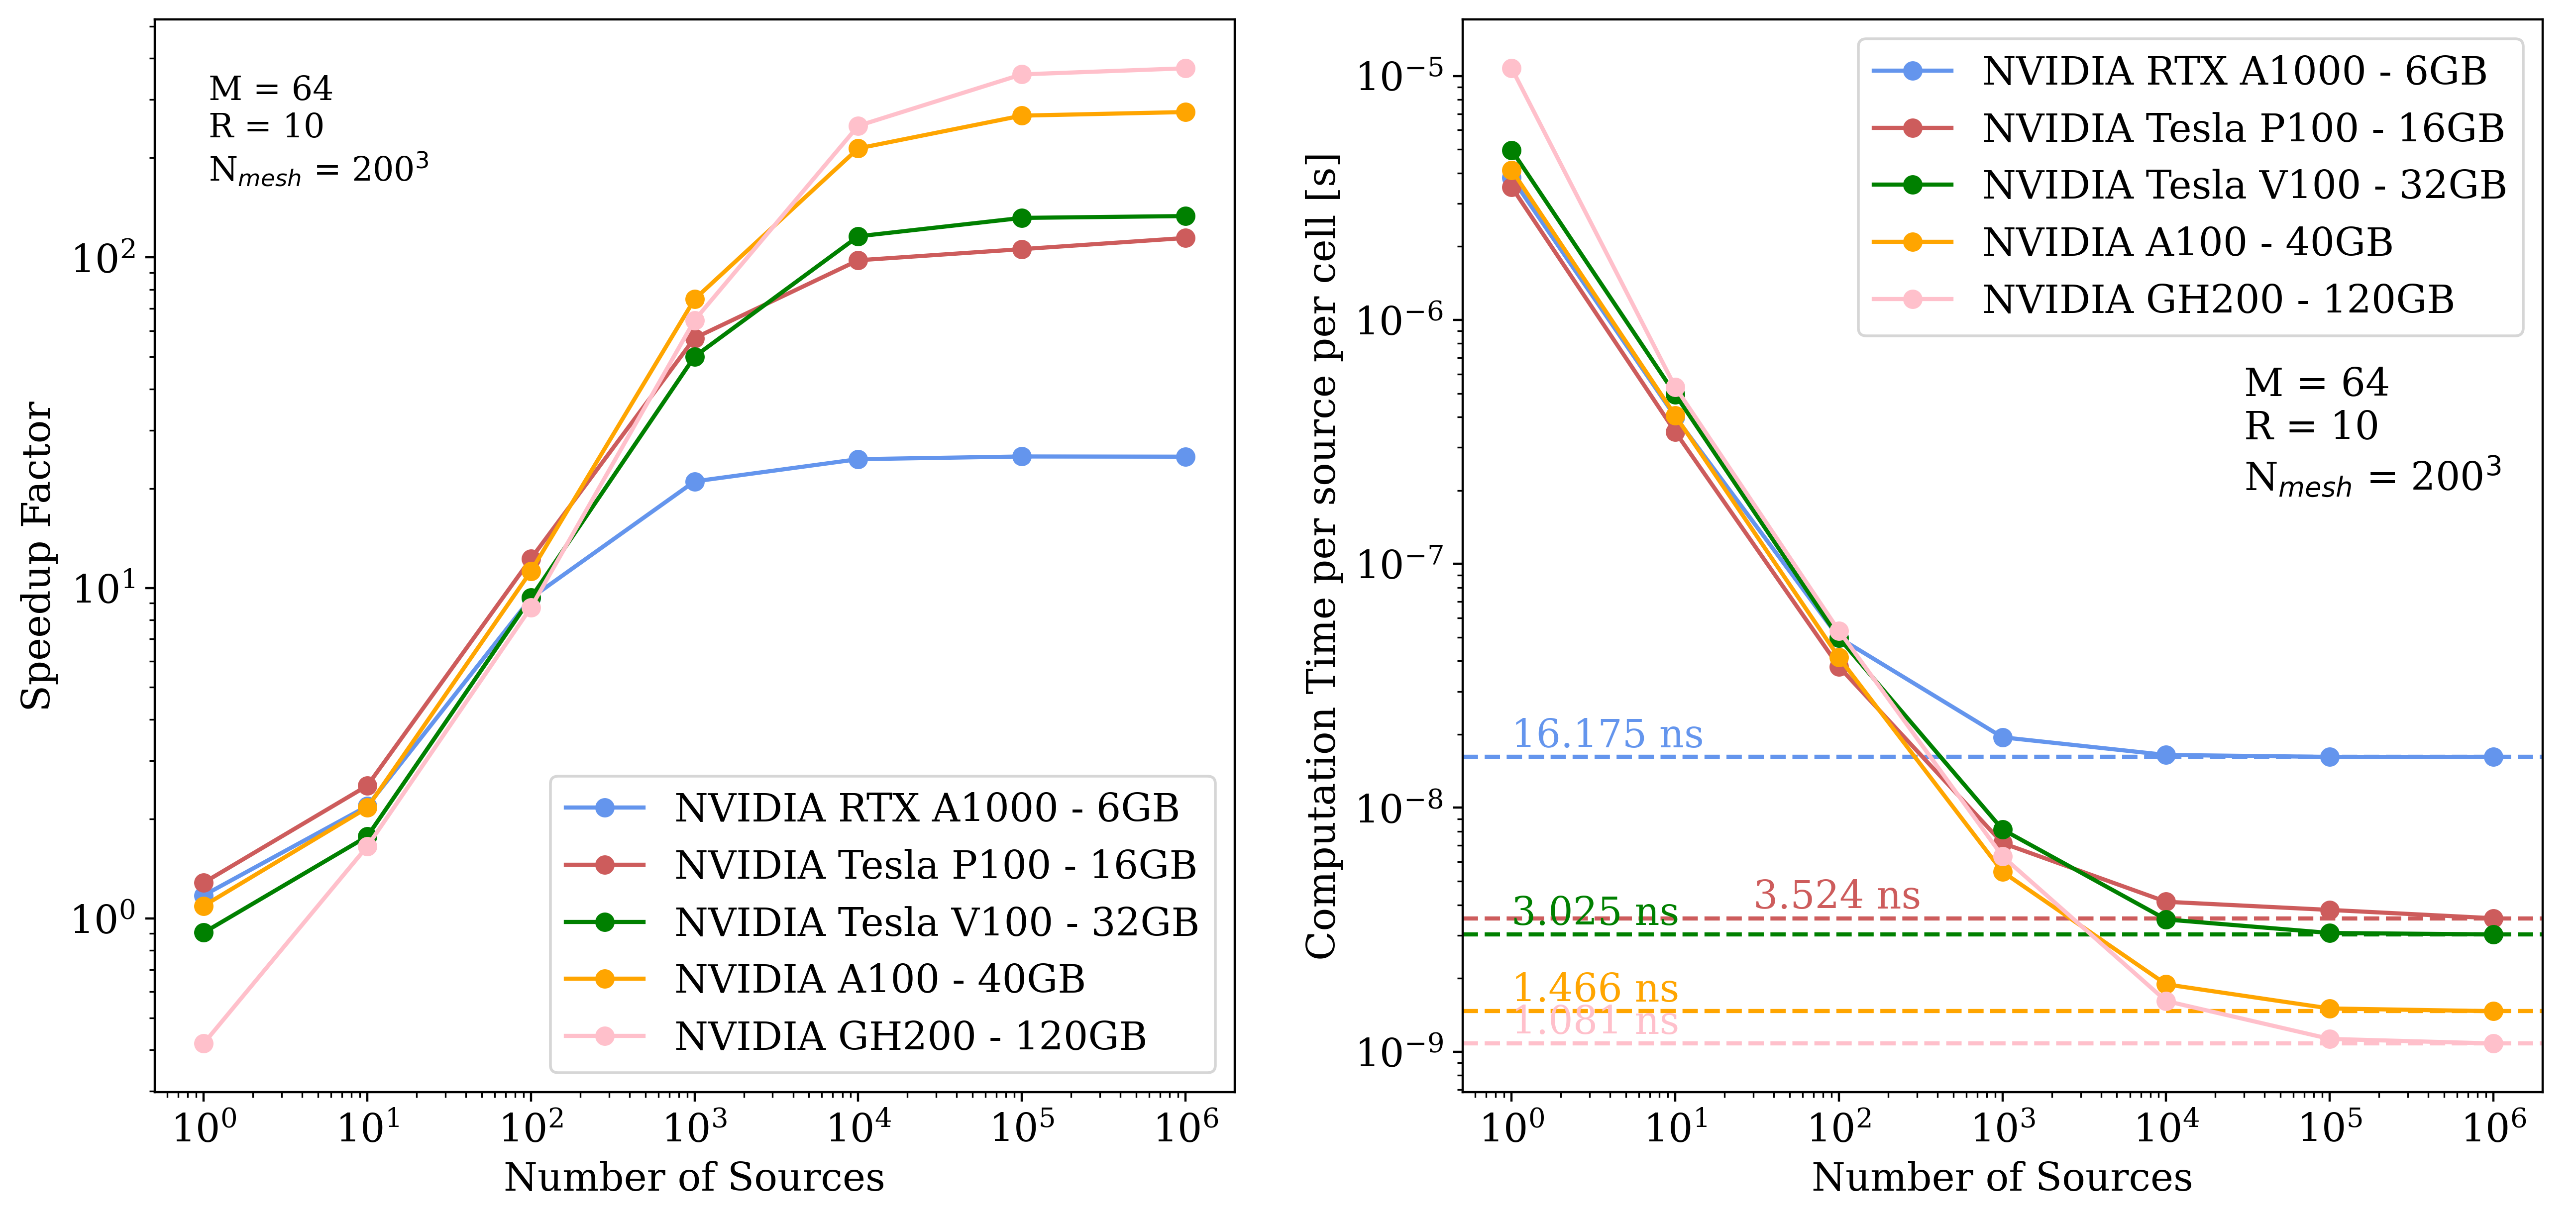

In [3]:
from IPython.display import Image, display
display(Image('../fig/summary_gpu_speedup_pyc2ray.png', width=900))

Moreover, the pannel on the right show time needed to compute the raytracing on once cell per source. This analysis show sthat the $\texttt{ASORA}$ raytracing algorithm approaches a phisical limit when increasing the number of sources.

We can use this quantity to estimate the computational time required for your simulation:

$$ t_\mathrm{sim} < \frac{4\pi}{3} \, R^3 \, t_\mathrm{lim} \, N_\mathrm{src} \, N_\mathrm{loop} \, N_\mathrm{redshift}\, N_\mathrm{inter}$$

- $t_\mathrm{sim}$ : the physical limit depending on the GPU architecture.
- $N_\mathrm{loop}$ : the number of convergence loop. This vary but generally is $\leq 10$.
- $N_\mathrm{redshift}$ : the number of redshift steps, which indicates how many time we call the raytracing algorithm. This is $\sim 100$ between $z=20$ and $6$.
- $N_\mathrm{inter}$ : the number of intermediate steps between redshift step. Increasing this quantity generally decreases the number of convergence loop (casuality). Generally it is set to 2.
- $R$ : the maximum distance that photon can travel in __pixel unit__ (`R_max_cMpc` in parameter file is in cMpc unit).
- $M$ : sources batch size, i.e. the number of sources done in parallel on the GPU (`source_batch_size` in parameter file).
- $N_\mathrm{src}$ : number of sources. This quantity is variable and not defined in the parameter file. Cosmological simulations generally have $\sim 10^6$ or more at low redshift.

Keep in mind that this is an upper limit. As we expect to have $N_\mathrm{src}\sim 10^6$ only from $z<12$ (depending on the simulation).

In [4]:
# for a cluster with NVIDIA A100
t_lim = 1.466*u.ns

# in pixel unit, for instance, if the resolution is of 2 cMpc this quantity will correspond to 30 cMpc (R_max_cMpc in parameter file)
R = 15

# here we assume that at all redshift step there are 1e6 sources and 10 convergence loop
Nsrc, Nloop, Nred, Ninter = 1e6, 10, 100, 2

t_sim = 4*np.pi/3*R**3*Nsrc*Nloop*Nred*Ninter*t_lim
print(' Expected computational time: t_sim <', t_sim.to('h'))

 Expected computational time: t_sim < 11.513937075406592 h


## GPU memory usage

However, we are often limited by the GPU memory. Therefore to help you setup you simulation and undestand its memory usage of your can estimate it by the following equation:

$$ \mathrm{GPU\,memory\,[GB]} = \left[3\,N_\mathrm{grid}^3 + \left(\sqrt{2} R \right)^3\right] \cdot M \cdot 4\,N_\mathrm{src} \cdot 8\,/\,10^9$$

The variable mentioned in the variables are employed by pyC$^2$Ray and are defined in a YAML file, `parameters.yml`, and they are:
- $N_\mathrm{grid}$ : the grid mesh-size per side (`meshsize` in parameter file)
- $R$ : the maximum distance that photon can travel in pixel unit (`R_max_cMpc` in parameter file is in cMpc unit)
- $M$ : sources batch size, i.e. the number of sources done in parallel on the GPU (`source_batch_size` in parameter file)
- $N_\mathrm{src}$ : number of sources. This quantity is variable and not defined in the parameter file. Cosmological simulations generally have $\sim 10^6$ or more at low redshift.

In [5]:
def memory_usage(paramfile, Nsrc):
    with open(paramfile,'r') as f:
        params = yaml.load(f, yaml.CSafeLoader)
    
    Nmesh = params['Grid']['meshsize']
    R = params['Sinks']['R_max_cMpc']/params['Grid']['boxsize']*params['Grid']['meshsize']*params['Cosmology']['h']
    if(R>Nmesh):
        R = Nmesh
    M = params['Raytracing']['source_batch_size']
    mem_us = ((3*Nmesh**3 + (np.sqrt(2)*R)**3)*M+4*Nsrc)*8/1e9
    print('Memory usage (N_src=%.0e): %.3f GB' %(Nsrc, mem_us))
    
paramfile = 'parameters.yml'

memory_usage(paramfile=paramfile, Nsrc=1e6)

Memory usage (N_src=1e+06): 0.435 GB


[  1.   2.   4.   8.  16.  32.  64. 128.]


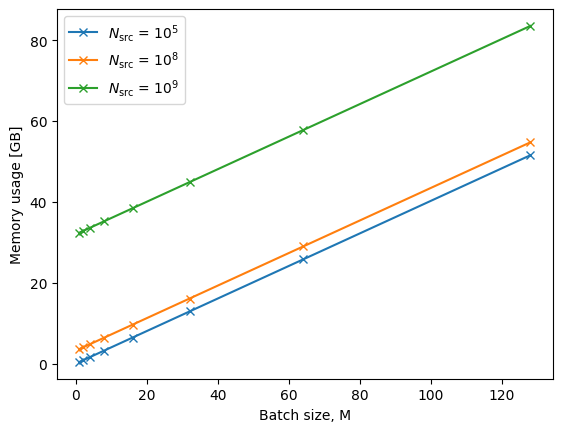

(None, None)

<Figure size 640x480 with 0 Axes>

In [6]:
Nmesh = 256
M = 2**np.linspace(0, 7, 8)
R = 10
print(M)

for Nsrc in [1e5, 1e8, 1e9]:
    mem_us = ((3*Nmesh**3 + (np.sqrt(2)*R)**3)*M+4*Nsrc)*8/1e9

    plt.plot(M, mem_us, 'x-', label=r'$N_\mathrm{src}$ = $10^%d$' %np.log10(Nsrc))
    plt.xlabel('Batch size, M'), plt.ylabel('Memory usage [GB]')

plt.legend()
plt.show(), plt.clf()